In [1]:
import os
import sys
import pandas as pd
import numpy as np
import sourmash
import screed
import time
import subprocess
import plotnine

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn
from io import StringIO

In [3]:
input_tax="/vortexfs1/omics/alexander/akrinos/remodeling/EUKulele/databases/marmmetsp_better_diatom_taxonomy/tax-table.txt"
dir_in="../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/"
seqid = 65
tax_level = "family"
## evaluate process of clustering with tax coherence.
tax_table = pd.read_csv(input_tax,sep="\t")
tax_table.columns = [curr.lower() for curr in tax_table.columns]

tax_table["domain"] = [str(curr).strip() for curr in tax_table.domain]
tax_table["supergroup"] = [str(curr).strip() for curr in tax_table.supergroup]
tax_table["division"] = [str(curr).strip() for curr in tax_table.division]
tax_table["class"] = [str(curr).strip() for curr in tax_table["class"]]
tax_table["order"] = [str(curr).strip() for curr in tax_table.order]
tax_table["family"] = [str(curr).strip() for curr in tax_table.family]
tax_table["genus"] = [str(curr).strip() for curr in tax_table.genus]
tax_table["species"] = [str(curr).strip() for curr in tax_table.species]
tax_table_sseq=tax_table.copy()
tax_table_sseq.columns=[curr+"_sseq" for curr in tax_table_sseq.columns]

## Select all Bacillariophyta families
list_fams = list(set(tax_table.loc[[(curr.strip()=="Bacillariophyta") for curr in tax_table["class"]],"family"])) #["Hemiaulaceae","Rhizosoleniaceae","Skeletonemataceae","Thalassiosiraceae"]
list_fams = list(set(tax_table.loc[[(curr.strip()=="Eukaryota") for curr in tax_table["domain"]],"family"]))
print(list_fams,flush=True)
all_frame_90 = pd.DataFrame()
all_frame_80 = pd.DataFrame()
all_frame_70 = pd.DataFrame()
all_frame_50 = pd.DataFrame()
list_frames = [all_frame_90,all_frame_80,all_frame_70,all_frame_50]
list_pidents = [90,80,70,50]

for curr in os.listdir(dir_in):
    input_small_file = os.path.join(dir_in,curr)

    df = pd.read_csv(input_small_file, sep="\t", header=None,names=["qseqid","sseqid","pident","length",
                                        "mismatch","gapopen","qstart","qend","sstart","send",
                                        "evalue","bitscore"])
    
    
    if len(df.index)==0:
        continue

    ## Get source ID from the opposite hit and merge with tax table to check if same family
    a = df.qseqid.str.split("_",expand=True)
    df["source_id"] = [col3 if (col1!=col1)|(col1 is None) else col1 if (col2!=col2)|(col2 is None) else col2 for col2,col1,col3 in zip(a.iloc[:,-1],a.iloc[:,-2],a.iloc[:,-3])]#a.iloc[:,-1]
    
    
    a = df.sseqid.str.split("_",expand=True)
    df["source_id_sseq"] = [col3 if (col1!=col1)|(col1 is None) else col1 if (col2!=col2)|(col2 is None) else col2 for col2,col1,col3 in zip(a.iloc[:,-1],a.iloc[:,-2],a.iloc[:,-3])]#a.iloc[:,-1]
    #print(list(df["source_id"])[1:3],flush=True)
    df = df.merge(tax_table,how="left")
    df = df.merge(tax_table_sseq,how="left")
    
    ## filter out uncertain classifications or unclassified levels.
    df = df.loc[[("_X" not in str(curr))&("_X" not in str(curr2))&\
                                 (curr2==curr2)&(curr==curr)&(curr2!="Unclassified")&\
                                 (curr!="Unclassified") for curr,curr2 in zip(df.order,
                                                                              df.order_sseq)]]
    df = df.loc[[("_X" not in str(curr))&("_X" not in str(curr2))&\
                                 (curr2==curr2)&(curr==curr)&(curr2!="Unclassified")&\
                                 (curr!="Unclassified") for curr,curr2 in zip(df.family,
                                                                              df.family_sseq)]]

    ## Now we have the list of sequences and whether or not they contain a match
    df["Matched"] = ["Self" if qs==ss else "Conflict" if fam1!=fam2 else\
                     "GoodHit" if fam1==fam2 else "unknown" for qs,ss,fam1,fam2 in \
                     zip(df.qseqid,df.sseqid,df.family,df.family_sseq)]
    for i, curr_df in enumerate(list_frames): 
        curr_pident=list_pidents[i]
        list_frames[i]=pd.concat([list_frames[i],
                             df.loc[df.pident>=curr_pident].\
                             loc[:,["qseqid","division","Matched","family","order"]].\
                             drop_duplicates(subset=["qseqid","division","Matched","family","order"])])
    
    print(curr,"done",flush=True)

['Cyanoptycaceae', 'Peridiniales_X', 'Acanthoecida_X', 'Vaucheriaceae', 'Crustomastigaceae', 'Trichosidae', 'Filamoebidae', 'Entomoneidaceae', 'Erythropeltidales_X', 'Staurosiraceae', 'Pelagomonadaceae', 'Corethraceae', 'Odontellaceae', 'Prasinococcales-Clade-A', 'Chlorophyta_XXX', 'Bicoecaceae', 'Cyrtolophosidida', 'Euplotidae', 'Lecudinidae', 'Rotaliidae', 'Chlamydomonadales_X', 'Fabreidae', 'Stylonematales-Group-II', 'Catenulaceae', 'Nephroselmidales_X', 'Dictyochales', 'Grammatophoraceae', 'Bathycoccaceae', 'Condylostomatidae', 'Noctilucaceae', 'Eutreptiales', 'Chattonellaceae', 'Stephanopyxidaceae', 'Pontosphaeraceae', 'Vitrellaceae', 'Coccolithaceae', 'Pedinellacaee', 'Philasterida', 'Thecofilosea_XX', 'Chrysochromulinaceae', 'Paramoebidae', 'Thalassiosiraceae', 'Strombidinopsidae', 'Bacillariaceae', 'Noelaerhabdaceae', 'Chromulinaceae', 'Discosea_XXX', 'Pyramimonadales_XX', 'Naviculaceae', 'Prasinococcales-Clade-B', 'Crypthecodiniaceae', 'Coscinodiscaceae', 'Colepidae', 'Kryptop

In [4]:
merged_plus_pivot_all = pd.DataFrame()
for i, curr_df in enumerate(list_frames):  
    dups_dropped=list_frames[i].drop_duplicates()
    counted_results = dups_dropped.groupby(["division","Matched","family","order"])["qseqid"].count().reset_index()
    counted_results_tot = dups_dropped.groupby("family")["qseqid"].count().reset_index().\
        rename({"qseqid":"TotalPer"},axis="columns")
    merged_plus_pivot = counted_results.merge(counted_results_tot,how="left").pivot(index=['family',"division",
                                                                      "order","TotalPer"],
                                                                columns="Matched", values="qseqid").reset_index()
    merged_plus_pivot.columns = [str(curr) for curr in merged_plus_pivot.columns]
    merged_plus_pivot["proportionGoodHit"] = merged_plus_pivot["GoodHit"]/merged_plus_pivot.TotalPer
    merged_plus_pivot["proportionConflict"] = merged_plus_pivot["Conflict"]/merged_plus_pivot.TotalPer
    merged_plus_pivot["Pident"] = list_pidents[i]
    merged_plus_pivot_all = pd.concat([merged_plus_pivot_all,merged_plus_pivot])

In [ ]:
input_tax="/vortexfs1/omics/alexander/akrinos/remodeling/EUKulele/databases/marmmetsp_better_diatom_taxonomy/tax-table.txt"
dir_in="../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/"
seqid = 65
tax_level = "family"
## evaluate process of clustering with tax coherence.
tax_table = pd.read_csv(input_tax,sep="\t")
tax_table.columns = [curr.lower() for curr in tax_table.columns]

tax_table["domain"] = [str(curr).strip() for curr in tax_table.domain]
tax_table["supergroup"] = [str(curr).strip() for curr in tax_table.supergroup]
tax_table["division"] = [str(curr).strip() for curr in tax_table.division]
tax_table["class"] = [str(curr).strip() for curr in tax_table["class"]]
tax_table["order"] = [str(curr).strip() for curr in tax_table.order]
tax_table["family"] = [str(curr).strip() for curr in tax_table.family]
tax_table["genus"] = [str(curr).strip() for curr in tax_table.genus]
tax_table["species"] = [str(curr).strip() for curr in tax_table.species]
tax_table_sseq=tax_table.copy()
tax_table_sseq.columns=[curr+"_sseq" for curr in tax_table_sseq.columns]

## Select all Bacillariophyta families
list_fams = list(set(tax_table.loc[[(curr.strip()=="Bacillariophyta") for curr in tax_table["class"]],"family"])) #["Hemiaulaceae","Rhizosoleniaceae","Skeletonemataceae","Thalassiosiraceae"]
list_fams = list(set(tax_table.loc[[(curr.strip()=="Eukaryota") for curr in tax_table["domain"]],"family"]))
print(list_fams,flush=True)
all_frame_90_compare = pd.DataFrame()
all_frame_80_compare = pd.DataFrame()
all_frame_70_compare = pd.DataFrame()
all_frame_50_compare = pd.DataFrame()
list_frames_compare = [all_frame_90_compare,all_frame_80_compare,
               all_frame_70_compare,all_frame_50_compare]
list_pidents = [90,80,70,50]

for curr in os.listdir(dir_in):
    input_small_file = os.path.join(dir_in,curr)

    df = pd.read_csv(input_small_file, sep="\t", header=None,names=["qseqid","sseqid","pident","length",
                                        "mismatch","gapopen","qstart","qend","sstart","send",
                                        "evalue","bitscore"])
    
    
    if len(df.index)==0:
        continue

    ## Get source ID from the opposite hit and merge with tax table to check if same family
    a = df.qseqid.str.split("_",expand=True)
    df["source_id"] = [col3 if (col1!=col1)|(col1 is None) else col1 if (col2!=col2)|(col2 is None) else col2 for col2,col1,col3 in zip(a.iloc[:,-1],a.iloc[:,-2],a.iloc[:,-3])]#a.iloc[:,-1]
    
    
    a = df.sseqid.str.split("_",expand=True)
    df["source_id_sseq"] = [col3 if (col1!=col1)|(col1 is None) else col1 if (col2!=col2)|(col2 is None) else col2 for col2,col1,col3 in zip(a.iloc[:,-1],a.iloc[:,-2],a.iloc[:,-3])]#a.iloc[:,-1]
    #print(list(df["source_id"])[1:3],flush=True)
    df = df.merge(tax_table,how="left")
    df = df.merge(tax_table_sseq,how="left")
    
    ## filter out uncertain classifications or unclassified levels.
    df = df.loc[[("_X" not in str(curr))&("_X" not in str(curr2))&\
                                 (curr2==curr2)&(curr==curr)&(curr2!="Unclassified")&\
                                 (curr!="Unclassified") for curr,curr2 in zip(df.order,
                                                                              df.order_sseq)]]
    df = df.loc[[("_X" not in str(curr))&("_X" not in str(curr2))&\
                                 (curr2==curr2)&(curr==curr)&(curr2!="Unclassified")&\
                                 (curr!="Unclassified") for curr,curr2 in zip(df.family,
                                                                              df.family_sseq)]]

    ## Now we have the list of sequences and whether or not they contain a match
    df["Matched"] = ["Self" if qs==ss else "Conflict" if fam1!=fam2 else\
                     "GoodHit" if fam1==fam2 else "unknown" for qs,ss,fam1,fam2 in \
                     zip(df.qseqid,df.sseqid,df.family,df.family_sseq)]
    for i, curr_df in enumerate(list_frames_compare): 
        curr_pident=list_pidents[i]
        list_frames_compare[i]=pd.concat([list_frames_compare[i],
                             df.loc[df.pident>=curr_pident].\
                             loc[:,["qseqid","division","Matched","family","order",
                                    "family_sseq","division_sseq"]].\
                             drop_duplicates(subset=["qseqid","division","Matched","family","family_sseq",
                                                     "order","division_sseq"])])
    
    print(curr,"done",flush=True)

['Phaeocystaceae', 'Filosa-Thecofilosea_XX', 'Corethraceae', 'Rosalidae', 'Vahlkampfiidae', 'Prorocentraceae', 'Prasinococcales-Clade-B', 'Goniodomataceae', 'Globothalamea_XX', 'Cafeteriaceae', 'Labyrinthulaceae', 'Glaucocystophytes_X', 'Acanthoecida_X', 'Thraustochytriaceae', 'Pseudokeronopsidae', 'Amphipleuraceae', 'Euplotidae', 'Picocystaceae', 'Cyclophoraceae', 'Stauroneidaceae', 'Mallomonadaceae', 'Blepharismidae', 'Goniomonadales_X', 'Calcidiscaceae', 'Saccharomycetales', 'Bathycoccaceae', 'Dictyochophyceae_XX', 'Noelaerhabdaceae', 'Soritidae', 'Philasterida', 'Cyrtolophosidida', 'Pycnococcaceae', 'Thalassionemataceae', 'Rhizochromulinaceae', 'Hacrobia_XXXX', 'Fabreidae', 'Gymnodiniaceae', 'Stephanopyxidaceae', 'Compsopogonales_X', 'Oxyrrhinaceae', 'Licmophoraceae', 'Thoracosphaeraceae', 'Discosea_XXX', 'Chrysochromulinaceae', 'Cryptomonadales_X', 'Dolichomastigaceae', 'Pavlovaceae', 'Paraphysomonadaceae', 'Pleurostomatida', 'Vexilliferidae', 'Pelagomonadales_X', 'Sarcinochrysida

In [34]:
list_pidents

[90, 80, 70, 50]

In [37]:
list_frames_compare[0].groupby("qseqid")["Matched"].agg(set).reset_index().sort_values("Matched")

,qseqid,Matched
0,AAB88914.1_MMP02603985_MMP02603985,{Self}
11378593,CAMPEP_0185845752_MMETSP1354,{Self}
11378592,CAMPEP_0185845750_MMETSP1354,{Self}
11378591,CAMPEP_0185845748_MMETSP1354,{Self}
11378590,CAMPEP_0185845746_MMETSP1354,{Self}
...,...,...
7957615,CAMPEP_0177426460_MMETSP0368,"{GoodHit, Self, Conflict}"
2968565,CAMPEP_0116204276_MMETSP0382,"{Conflict, GoodHit, Self}"
7957614,CAMPEP_0177426458_MMETSP0368,"{GoodHit, Self, Conflict}"
7957621,CAMPEP_0177426472_MMETSP0368,"{GoodHit, Self, Conflict}"


In [ ]:
merged_plus_pivot_all_compare = pd.DataFrame()
for i, curr_df in enumerate(list_frames_compare):  
    dups_dropped=list_frames_compare[i].drop_duplicates()
    counted_results = dups_dropped.groupby(["division","Matched","family",
                                            "family_sseq","order"])["qseqid"].count().reset_index().fillna(0)
    counted_results_tot = dups_dropped.groupby(["family"])["qseqid"].count().reset_index().\
        rename({"qseqid":"TotalPer"},axis="columns")
    merged_plus_pivot = counted_results.merge(counted_results_tot,how="left").pivot(index=['family',"division",
                                                                      "order","TotalPer","family_sseq"],
                                                                columns="Matched", values="qseqid").\
        reset_index().fillna(0)
    merged_plus_pivot.columns = [str(curr) for curr in merged_plus_pivot.columns]
    merged_plus_pivot["proportionGoodHit"] = merged_plus_pivot["GoodHit"]/merged_plus_pivot.TotalPer
    merged_plus_pivot["proportionConflict"] = merged_plus_pivot["Conflict"]/merged_plus_pivot.TotalPer
    merged_plus_pivot["Pident"] = list_pidents[i]
    merged_plus_pivot_all_compare = pd.concat([merged_plus_pivot_all_compare,merged_plus_pivot])

In [5]:
input_tax="/vortexfs1/omics/alexander/akrinos/remodeling/EUKulele/databases/marmmetsp_better_diatom_taxonomy/tax-table.txt"

tax_level = "family"
## evaluate process of clustering with tax coherence.
tax_table = pd.read_csv(input_tax,sep="\t")
tax_table.columns = [curr.lower() for curr in tax_table.columns]

tax_table["domain"] = [str(curr).strip() for curr in tax_table.domain]
tax_table["supergroup"] = [str(curr).strip() for curr in tax_table.supergroup]
tax_table["division"] = [str(curr).strip() for curr in tax_table.division]
tax_table["class"] = [str(curr).strip() for curr in tax_table["class"]]
tax_table["order"] = [str(curr).strip() for curr in tax_table.order]
tax_table["family"] = [str(curr).strip() for curr in tax_table.family]
tax_table["genus"] = [str(curr).strip() for curr in tax_table.genus]
tax_table["species"] = [str(curr).strip() for curr in tax_table.species]
summed_by_fam=tax_table.groupby("family")["domain"].count().reset_index().sort_values("domain",
                          ascending=False)

In [6]:
merged_in=merged_plus_pivot_all.merge(summed_by_fam,how="left")

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is 

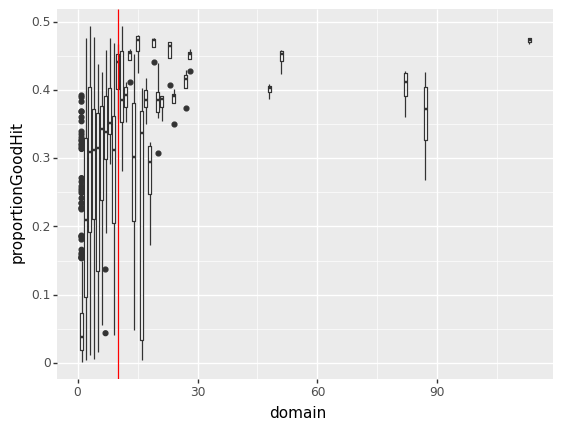

<ggplot: (2932242240919)>

In [7]:
(plotnine.ggplot(merged_in) + plotnine.geom_boxplot(plotnine.aes(x = "domain", y = "proportionGoodHit",
                                                                 group = "domain"))+
    plotnine.geom_vline(plotnine.aes(xintercept=10),color="red"))

In [95]:
p_same_fam =(plotnine.ggplot(merged_in.loc[merged_in.division.isin(["Ochrophyta","Chlorophyta","Dinoflagellata",
                                                        "Haptophyta","Apicomplexa",
                                                        "Ciliophora","Cryptophyta"])]) + 
    plotnine.geom_boxplot(plotnine.aes(x = "domain", y = "proportionGoodHit",
                                       group = "domain"))+
    plotnine.geom_jitter(plotnine.aes(x = "domain", y = "proportionGoodHit",
                                      shape="division"),size=2,alpha=0.5,color="gray")+
    plotnine.geom_vline(plotnine.aes(xintercept=10),color="red")+
    plotnine.scale_shape_manual(values=["^","v","<",">","s","*"])+
    plotnine.xlab("Number of transcriptome references")+plotnine.theme_bw(base_size=14)+
    plotnine.theme(legend_key_size=30)+ 
    plotnine.guides(shape = plotnine.guide_legend(override_aes = {"size" :5}))+
    plotnine.ylab("Proportion of sequences with non-self hit in same Family"))
p_same_fam.save("hits_to_same_fam.pdf",width=7,height=7,units="in")

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 7 x 7 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: hits_to_same_fam.pdf
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/e

In [74]:
for_boxplot = merged_in.loc[merged_in.division.isin(["Ochrophyta","Chlorophyta","Dinoflagellata",
                                                        "Haptophyta","Apicomplexa",
                                                        "Ciliophora","Cryptophyta"])].\
    loc[:,["division","Pident","domain","order","family","proportionGoodHit","proportionConflict"]].\
    melt(id_vars=["division","Pident","domain","order","family"])
for_boxplot["group"]=for_boxplot.Pident.astype(str)+for_boxplot.variable.astype(str)

In [94]:
p_conflict_assess=(plotnine.ggplot(for_boxplot) + 
    plotnine.geom_boxplot(plotnine.aes(x = "Pident", y = "value", group = "group", fill = "variable"),
                         width=3)+
    plotnine.scale_shape_manual(values=["^","v","<",">","s","*"])+
    plotnine.xlab("Number of transcriptome references")+plotnine.theme_bw(base_size=14)+
    plotnine.theme(legend_key_size=30)+ 
    plotnine.guides(shape = plotnine.guide_legend(override_aes = {"size" :5}))+
    plotnine.ylab("Proportion of sequences")+
    plotnine.xlab("Percentage identity")+
    plotnine.scale_fill_manual(breaks=["proportionGoodHit","proportionConflict"],
                               labels=["Same family","Conflicting family"],
                               values=["#1A85FF","#D41159"],
                               name="Match type"))
p_conflict_assess.save("p_conflict_assess.pdf",width=7,height=7,units="in")

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 7 x 7 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: p_conflict_assess.pdf
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplot

In [29]:
merged_in

,family,division,order,TotalPer,Conflict,GoodHit,Self,proportionGoodHit,proportionConflict,Pident,domain
0,Acaryochloridaceae,Cyanobacteria,Synechococcales,9445,23.0,1040.0,8382.0,0.110111,0.002435,90,1
1,Acidimicrobiaceae,Actinobacteria,Acidimicrobiales,4304,3.0,15.0,4286.0,0.003485,0.000697,90,1
2,Actinomycetaceae,Actinobacteria,Actinomycetales,1715,3.0,28.0,1684.0,0.016327,0.001749,90,1
3,Aeromonadaceae,Gammaproteobacteria,Aeromonadales,40540,418.0,16846.0,23276.0,0.415540,0.010311,90,6
4,Alcaligenaceae,Betaproteobacteria,Burkholderiales,20658,103.0,6013.0,14542.0,0.291074,0.004986,90,4
...,...,...,...,...,...,...,...,...,...,...,...
1135,Woeseiaceae,Gammaproteobacteria,Chromatiales,5621,1934.0,122.0,3565.0,0.021704,0.344067,50,1
1136,Xanthomonadaceae,Gammaproteobacteria,Xanthomonadales,12625,3358.0,3264.0,6003.0,0.258535,0.265980,50,2
1137,Yersiniaceae,Gammaproteobacteria,Enterobacterales,36225,11167.0,12123.0,12935.0,0.334658,0.308268,50,3
1138,nan,delta/epsilon subdivisions,Campylobacterales,3260,1092.0,80.0,2088.0,0.024540,0.334969,50,1


In [26]:
merged_plus_pivot_ochr = merged_plus_pivot_all_compare.loc[merged_plus_pivot_all_compare.division=="Ochrophyta"]
merged_plus_pivot_ochr=merged_plus_pivot_ochr.\
    loc[(merged_plus_pivot_ochr.family!="Pedinellacaee")&(merged_plus_pivot_ochr.family_sseq!="Pedinellacaee")]
for_plt = merged_plus_pivot_ochr.loc[merged_plus_pivot_ochr.family!=\
                                            merged_plus_pivot_ochr.family_sseq].merge(tax_table.loc[:,["division","family"]].rename({"family":"family_sseq",
                                                                               "division":"division_sseq"},
                                                                              axis="columns"),
                             how = "left")
for_plt = for_plt.loc[for_plt.division_sseq == "Ochrophyta"]

from sklearn.cluster import AgglomerativeClustering
X = for_plt.loc[:,["family","Pident",
               "family_sseq","proportionConflict"]].drop_duplicates().\
    pivot(index=["family","Pident"],columns="family_sseq",values="proportionConflict").reset_index().fillna(0)
X = X.loc[X.Pident==90]
clustering = AgglomerativeClustering(n_clusters=4).fit(X.drop(["family","Pident"],axis="columns"))
X["cluster"] = clustering.labels_
X = X.sort_values("cluster")

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:370: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


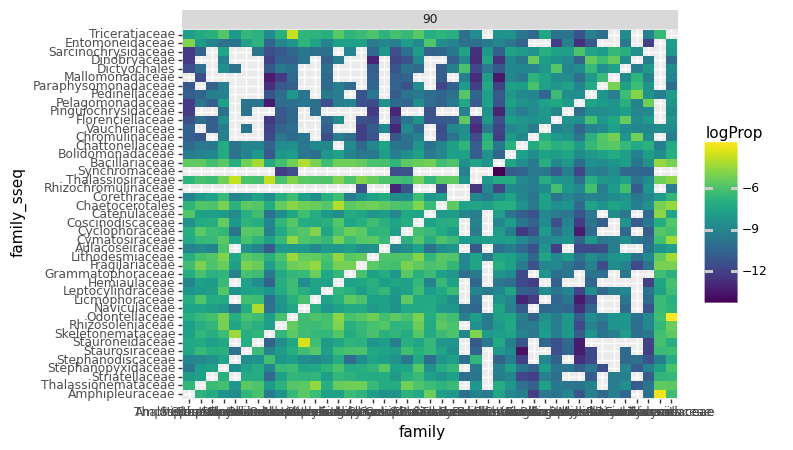

<ggplot: (2932636347010)>

In [27]:
merged_plus_pivot_ochr = merged_plus_pivot_all_compare.loc[merged_plus_pivot_all_compare.division=="Ochrophyta"]
merged_plus_pivot_ochr=merged_plus_pivot_ochr.\
    loc[(merged_plus_pivot_ochr.family!="Pedinellacaee")&(merged_plus_pivot_ochr.family_sseq!="Pedinellacaee")]
for_plt = merged_plus_pivot_ochr.loc[merged_plus_pivot_ochr.family!=\
                                            merged_plus_pivot_ochr.family_sseq].merge(tax_table.loc[:,["division","family"]].rename({"family":"family_sseq",
                                                                               "division":"division_sseq"},
                                                                              axis="columns"),
                             how = "left")
for_plt = for_plt.loc[for_plt.division_sseq == "Ochrophyta"]
for_plt=for_plt.loc[for_plt.Pident==90,:]
for_plt["family"] = pd.Categorical(for_plt["family"],categories=X.family)
for_plt["family_sseq"] = pd.Categorical(for_plt["family_sseq"],categories=X.family)
for_plt["logProp"] = np.log(for_plt.proportionConflict)

(plotnine.ggplot(for_plt)+
     plotnine.geom_tile(plotnine.aes(x = "family", y = "family_sseq", fill = "logProp")) +
     plotnine.facet_wrap("Pident",scales="free_y"))

In [61]:
merged_plus_pivot_ochr = merged_plus_pivot_all_compare.loc[merged_plus_pivot_all_compare.division=="Ochrophyta"]
merged_plus_pivot_ochr=merged_plus_pivot_ochr.\
    loc[(merged_plus_pivot_ochr.family!="Pedinellacaee")&(merged_plus_pivot_ochr.family_sseq!="Pedinellacaee")]
for_plt = merged_plus_pivot_ochr.loc[merged_plus_pivot_ochr.family!=\
                                            merged_plus_pivot_ochr.family_sseq].merge(tax_table.loc[:,["division","family"]].rename({"family":"family_sseq",
                                                                               "division":"division_sseq"},
                                                                              axis="columns"),
                             how = "left")
for_plt = for_plt.loc[for_plt.division_sseq == "Ochrophyta"]
#for_plt=for_plt.loc[for_plt.Pident==90,:]
for_plt["family"] = pd.Categorical(for_plt["family"],categories=X.family)
for_plt["family_sseq"] = pd.Categorical(for_plt["family_sseq"],categories=X.family)
for_plt["logProp"] = np.log(for_plt.proportionConflict)

fig=(plotnine.ggplot(for_plt)+
     plotnine.geom_tile(plotnine.aes(x = "family", y = "family_sseq", fill = "logProp")) +
     plotnine.scale_fill_cmap( name="log proportion\nof seqs") + 
     plotnine.facet_wrap("Pident")+plotnine.theme_bw(base_size=13)+plotnine.xlab("") + plotnine.ylab("")+
     plotnine.theme(axis_text_x=plotnine.element_text(rotation=90, hjust=0)))
fig
fig.save("percentage_identity_plots.png",height=12,width=12,units="in",dpi=400)
fig.save("percentage_identity_plots.pdf",height=12,width=12,units="in")

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 12 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: percentage_identity_plots.png
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:370: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 12 x 12 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Fil

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:370: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


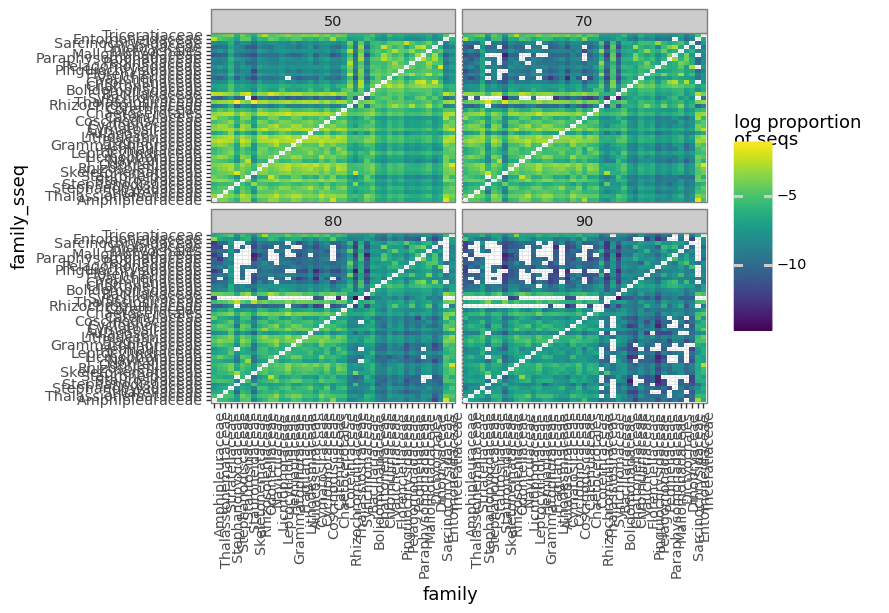

<ggplot: (2932977064566)>

In [59]:
fig